# Utils

In [4]:
import cryo
import polars as pl

In [5]:
def convert_to_type(data, type, data_offset = 0):
    ''' Convert raw data to a specific type
    data: the raw data (bytes)
    type: the type of the data
    data_offset: the offset of the data in the raw data'''
    
    if type == 'string':
        offset = int(data[data_offset: data_offset+32].hex(), 16)
        length = int(data[offset:offset + 32].hex(), 16)
        return data[offset + 32: offset + 32 + length].decode('utf-8')
    elif len(type) > 4 and type[:4] == 'uint':
        if (data[data_offset+22: data_offset+32].hex() == ''):
            return float(0)
        return float(int(data[data_offset+22: data_offset+32].hex(), 16))
    elif len(type) > 3 and type[:3] == 'int':
        if (data[data_offset+22: data_offset+32].hex() == ''):
            return float(0)
        return float(int(data[data_offset+22: data_offset+32].hex(), 16))
    elif type == 'address':
        return '0x' + data[12+data_offset:32+data_offset].hex()
    elif type == 'bool':
        return bool(int(data[data_offset: 32 + data_offset].hex(), 16) > 0)
    elif len(type) > 5 and type[:5] == 'bytes':
        bytes_left = 32 - int(type[5:])
        return '0x' + data[data_offset+bytes_left: data_offset+32].hex()
    else:
        raise ValueError("Type not handled yet")

def type_name(type):
    if type == 'string':
        return str
    elif len(type) > 4 and type[:4] == 'uint':
        return pl.Float64
    elif len(type) > 3 and type[:3] == 'int':
        return pl.Float64
    elif type == 'address':
        return str
    elif type == 'bool':
        return bool
    elif len(type) > 5 and type[:5] == 'bytes':
        return str
    else:
        raise ValueError("Type not handled yet")
    
def parse_raw_events(raw_events: pl.DataFrame, signature: str) -> pl.DataFrame:
    '''
    Parse raw events from a DataFrame, this dataframe should contain the following columns:
    - topic0 to topic3: the topics of the event
    - data: the data of the event
    The signature is used to determine the type of the event, it should look like this:
    "EventName(uint256 indexed arg1, uint256 indexed arg2, T arg3, ...)"

    The function works with basic types (string, uint, address, bool, bytes) but not yet (TODO) with arrays or structs.
    '''
    
    # Parse the signature
    first_parenthesis = signature.find('(')
    last_parenthesis = signature.rfind(')')

    # print(f'Parsing Event name: {signature[:first_parenthesis]}')

    types_str = signature[first_parenthesis + 1:last_parenthesis]
    types = types_str.split(',')
    indexed_types, data_types = [], []

    for t in types:
        parts = t.strip().split(' ')
        if 'indexed' in parts:
            indexed_types.append((parts[0], parts[-1]))
        else:
            data_types.append((parts[0], parts[-1]))

    dfs = []
    for index, (type, name) in enumerate(data_types):
        data_events_cur_df = raw_events.select([
            pl.col("data").map_elements(lambda x: convert_to_type(x, type, 32*index), return_dtype=type_name(type)).alias(name)
        ] + [pl.col("block_number"), pl.col("transaction_index", "log_index")])
        dfs.append(data_events_cur_df)

    indexed_events_df = raw_events.select([
        pl.col(f"topic{1+index}").map_elements(lambda x: convert_to_type(x, type), return_dtype=type_name(type)).alias(name)
        for index, (type, name) in enumerate(indexed_types)
    ] + [pl.col("block_number"), pl.col("transaction_index", "log_index")])

    # print(f'Indexed types: {indexed_types}')
    # print(f'Data types: {data_types}')
    

    res_df = indexed_events_df
    for df in dfs:
        res_df = res_df.join(df, on=["block_number", "transaction_index", "log_index"], how="inner")

    return res_df

# Tokens symbol query

from web3 import Web3
import os

# Connect to an Ethereum node, Infura for example
infura_url = os.getenv("ETH_RPC_URL")
web3 = Web3(Web3.HTTPProvider(infura_url))

# Make sure the connection is successful
if not web3.is_connected():
    print("Failed to connect to Ethereum network!")
    exit()

def get_symbol(asset: str):
    token_abi = [
        {
            'constant': True,
            'inputs': [],
            'name': 'symbol',
            'outputs': [
                {'name': '', 'type': 'string'}
            ],
            'payable': False,
            'stateMutability': 'view',
            'type': 'function'
        },
    ]
    token_contract = web3.eth.contract(address=asset, abi=token_abi)
    try:
        symbol = token_contract.functions.symbol().call()
    except:
        symbol = asset
    return symbol

In [6]:
# Block timestamps database

blocks: pl.DataFrame = (
    pl.scan_parquet("blocks__block_time/*.parquet")
    .collect()
)
blocks = blocks.with_columns(
    pl.col("timestamp").alias("temp")
)
blocks = blocks.with_columns(
    # Expects timestamps in micro seconds
    (pl.col("temp").cast(pl.Int64) * 1000000).cast(pl.Datetime)
)
blocks.columns = ['block_number', 'timestamp', 'time']

# Liquidation events

In [7]:
LIQUIDATION_EVENT_SIG = "event LiquidationCall(address indexed collateralAsset, address indexed debtAsset, address indexed user, uint256 debtToCover, uint256 liquidatedCollateralAmount, address liquidator, bool receiveAToken);"
LIQUIDATION_EVENT_HASH = "0xe413a321e8681d831f4dbccbca790d2952b56f977908e45be37335533e005286"
AAVE_V3_POOL = "0x87870Bca3F3fD6335C3F4ce8392D69350B4fA4E2"
AAVE_V2_POOL = "0x7d2768dE32b0b80b7a3454c06BdAc94A69DDc7A9"
DAI = "0x6b175474e89094c44da98b954eedeac495271d0f"
WETH = "0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2"
WBTC = "0x2260fac5e5542a773aa44fbcfedf7c193bc2c599"
USDC = "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48"
USDT = "0xdAC17F958D2ee523a2206206994597C13D831ec7"
STETH = "0xae7ab96520de3a18e5e111b5eaab095312d7fe84"
assets = [DAI, WETH, WBTC, USDC, USDT, STETH]

# Collect the raw events with specific cryo params
paramsV3 = {
    "datatype": "events",
    "blocks": ["16M:19.5M"], # AaveV3 deployed at 16291127
    "inner_request_size": 100_000,
    "contract": [AAVE_V3_POOL],
    "topic0": [LIQUIDATION_EVENT_HASH]
}
paramsV2 = {
    "datatype": "events",
    "blocks": ["11M:19.5M"], # AaveV2 deployed at 11362579
    "inner_request_size": 100_000,
    "contract": [AAVE_V2_POOL],
    "topic0": [LIQUIDATION_EVENT_HASH]
}

# Collect the raw events with cryo
liquidations_raw = pl.concat([
    cryo.collect(**paramsV2).with_columns(pl.lit("AaveV2").alias("protocol")), 
    cryo.collect(**paramsV3).with_columns(pl.lit("AaveV3").alias("protocol"))
])

# Parse the raw events to a DataFrame with a specific event signature
liquidations = parse_raw_events(liquidations_raw, LIQUIDATION_EVENT_SIG)
# liquidations = parse_raw_events(liquidations_raw, LIQUIDATION_EVENT_SIG).filter((pl.col("collateralAsset").is_in(assets)) & (pl.col("debtAsset").is_in(assets)))

# Add timestamps
liquidations = liquidations.join(blocks, on='block_number', how="left")
print(len(liquidations), "liquidations from", liquidations["time"].min(), "to", liquidations["time"].max())
liquidations.head(5)

30003 liquidations from 2020-12-17 14:19:27 to 2024-03-23 18:01:23


collateralAsset,debtAsset,user,block_number,transaction_index,log_index,debtToCover,liquidatedCollateralAmount,liquidator,receiveAToken,timestamp,time
str,str,str,u32,u32,u32,f64,f64,str,bool,u32,datetime[μs]
"""0x6b175474e890…","""0x2260fac5e554…","""0xa53fe221bd86…",11471171,28,56,74305.0,1.7806e19,"""0x7a512a3cf68d…",false,1608214767,2020-12-17 14:19:27
"""0xa0b86991c621…","""0xc02aaa39b223…","""0x9a90affd5fd5…",11471182,9,18,8.1674e18,5.6882e9,"""0x08b5cabc97b3…",false,1608214863,2020-12-17 14:21:03
"""0xa0b86991c621…","""0xc02aaa39b223…","""0x9a90affd5fd5…",11471183,106,217,4.0837e18,2.8441e9,"""0x7a512a3cf68d…",false,1608214892,2020-12-17 14:21:32
"""0xc02aaa39b223…","""0x2260fac5e554…","""0xa0b38f17b0ca…",11471194,24,67,63378.0,2.2994e16,"""0x7a512a3cf68d…",false,1608215016,2020-12-17 14:23:36
"""0x6b175474e890…","""0x2260fac5e554…","""0xa53fe221bd86…",11471465,190,312,37153.0,8.9030e18,"""0x7a512a3cf68d…",false,1608218435,2020-12-17 15:20:35


# Prices

In [8]:
# aggregators = pl.read_json("oracle-prices.json")

ANSWER_UPDATED_SIG = "AnswerUpdated(int256 indexed current,uint256 indexed roundId,uint256 timestamp)"
ANSWER_UPDATED_HASH = "0x0559884fd3a460db3073b7fc896cc77986f16e378210ded43186175bf646fc5f"

aggregators = {
    DAI: "0x478238a1c8B862498c74D0647329Aef9ea6819Ed",
    USDC: "0x789190466E21a8b78b8027866CBBDc151542A26C",
    WBTC: "0xdBe1941BFbe4410D6865b9b7078e0b49af144D2d",
    WETH: "0xE62B71cf983019BFf55bC83B48601ce8419650CC",
    USDT: "0xa964273552C1dBa201f5f000215F5BD5576e8f93",
    STETH: "0xdA31bc2B08F22AE24aeD5F6EB1E71E96867BA196",
}

def historical_prices(asset: str):
    print(asset)
    params = {
        "datatype": "events",
        "blocks": ["17M:19.5M"], # AaveV2 deployed at 11362579
        "inner_request_size": 100_000,
        "contract": [aggregators[asset]],
        "topic0": [ANSWER_UPDATED_HASH]
    }

    # cryo here sometimes randomly fails with "rust future panicked: unknown error" for a reason that I don't get.
    while True:
        try:
            prices_raw = cryo.collect(**params)
            break
        except:
            pass

    prices = parse_raw_events(prices_raw, ANSWER_UPDATED_SIG)
    prices = prices.with_columns(pl.lit(asset).alias("asset"))
    # Join blocks to get the time (and drop everything else).
    prices = prices.join(blocks, on='block_number', how="left")
    prices = prices.drop(["timestamp", "block_number", "timestamp_right", "transaction_index", "log_index", "roundId"])

    return prices

prices = pl.concat([historical_prices(asset) for asset in assets])
prices.tail(5)

0x6b175474e89094c44da98b954eedeac495271d0f


0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599
0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48
0xdAC17F958D2ee523a2206206994597C13D831ec7
0xae7ab96520de3a18e5e111b5eaab095312d7fe84


current,asset,time
f64,str,datetime[μs]
3.4094e11,"""0xae7ab96520de…",2024-03-23 16:33:35
3.4051e11,"""0xae7ab96520de…",2024-03-23 17:34:11
3.3994e11,"""0xae7ab96520de…",2024-03-23 18:34:35
3.3867e11,"""0xae7ab96520de…",2024-03-23 19:34:47
3.3821e11,"""0xae7ab96520de…",2024-03-23 20:35:23


In [9]:
for asset in assets:
    print(asset)
    print(prices.filter(pl.col('asset').cast(pl.Utf8) == asset)["time"].min())
    print(prices.filter(pl.col('asset').cast(pl.Utf8) == asset)["time"].max())

0x6b175474e89094c44da98b954eedeac495271d0f
2023-04-08 00:20:47
2024-03-23 21:30:35
0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2
2023-04-08 00:44:47
2024-03-23 20:55:23
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599
2023-04-08 00:44:59
2024-03-23 20:55:35
0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48
2023-04-08 08:00:23
2024-03-23 08:00:47
0xdAC17F958D2ee523a2206206994597C13D831ec7
2023-04-08 15:20:47
2024-03-23 12:46:11
0xae7ab96520de3a18e5e111b5eaab095312d7fe84
2023-04-08 00:41:47
2024-03-23 20:35:23


In [10]:
liquidations = liquidations.drop(["current", "current_right", "collateralAssetPrice", "debtAssetPrice", "collateralAssetDecimals", "debtAssetDecimals", "seized$", "repaid$"])

decimals = {
    USDC: 1e6,
    WBTC: 1e8,
    USDT: 1e6,
    DAI: 1e18,
    WETH: 1e18,
    STETH: 1e18
}

decimals_df = pl.DataFrame({
    "asset": list(decimals.keys()),
    "decimals": list(decimals.values())
})

liquidations = liquidations.join(
    decimals_df,
    left_on='collateralAsset',
    right_on='asset',
    how='left'
).rename({"decimals": "collateralAssetDecimals"})
liquidations = liquidations.join(
    decimals_df,
    left_on='debtAsset',
    right_on='asset',
    how='left'
).rename({"decimals": "debtAssetDecimals"})
liquidations = liquidations.with_columns(pl.lit(10).pow(pl.col('collateralAssetDecimals')))

prices_with_correct_name = prices.rename({"asset": "collateralAsset"})

liquidations = liquidations.join_asof(
    prices_with_correct_name,
    on="time",
    by="collateralAsset",
    strategy="backward"
)
liquidations = liquidations.rename({"current": "collateralAssetPrice"})

liquidations = liquidations.with_columns(
    (pl.col('collateralAssetPrice').truediv(1e8).mul(pl.col('liquidatedCollateralAmount')).truediv(pl.col('collateralAssetDecimals'))).alias('seized$')
)

prices_with_correct_name = prices.rename({"asset": "debtAsset"})
liquidations = liquidations.join_asof(
    prices_with_correct_name,
    on="time",
    by="debtAsset",
    strategy="backward"
)
liquidations = liquidations.rename({"current": "debtAssetPrice"})

liquidations = liquidations.with_columns(
    (pl.col('debtAssetPrice').truediv(1e8).mul(pl.col('debtToCover')).truediv(pl.col('debtAssetDecimals'))).alias('repaid$')
)
liquidations.head(50)

collateralAsset,debtAsset,user,block_number,transaction_index,log_index,debtToCover,liquidatedCollateralAmount,liquidator,receiveAToken,timestamp,time,collateralAssetDecimals,debtAssetDecimals,literal,collateralAssetPrice,seized$,debtAssetPrice,repaid$
str,str,str,u32,u32,u32,f64,f64,str,bool,u32,datetime[μs],f64,f64,f64,f64,f64,f64,f64
"""0x6b175474e890…","""0x2260fac5e554…","""0xa53fe221bd86…",11471171,28,56,74305.0,1.7806e19,"""0x7a512a3cf68d…",false,1608214767,2020-12-17 14:19:27,1.0000e18,1e8,inf,null,null,null,null
"""0xa0b86991c621…","""0xc02aaa39b223…","""0x9a90affd5fd5…",11471182,9,18,8.1674e18,5.6882e9,"""0x08b5cabc97b3…",false,1608214863,2020-12-17 14:21:03,null,null,null,null,null,null,null
"""0xa0b86991c621…","""0xc02aaa39b223…","""0x9a90affd5fd5…",11471183,106,217,4.0837e18,2.8441e9,"""0x7a512a3cf68d…",false,1608214892,2020-12-17 14:21:32,null,null,null,null,null,null,null
"""0xc02aaa39b223…","""0x2260fac5e554…","""0xa0b38f17b0ca…",11471194,24,67,63378.0,2.2994e16,"""0x7a512a3cf68d…",false,1608215016,2020-12-17 14:23:36,null,1e8,null,null,null,null,null
"""0x6b175474e890…","""0x2260fac5e554…","""0xa53fe221bd86…",11471465,190,312,37153.0,8.9030e18,"""0x7a512a3cf68d…",false,1608218435,2020-12-17 15:20:35,1.0000e18,1e8,inf,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""0xc02aaa39b223…","""0xdac17f958d2e…","""0xd88b54b2a4df…",11611231,130,150,1.6320e9,1.4512e18,"""0x1872ab0b3327…",false,1610071861,2021-01-08 02:11:01,null,null,null,null,null,null,null
"""0xc02aaa39b223…","""0xa0b86991c621…","""0x4396a292512a…",11611389,85,219,3.1466e10,2.9791e19,"""0x2ca158422b94…",false,1610073905,2021-01-08 02:45:05,null,null,null,null,null,null,null
"""0xc02aaa39b223…","""0xa0b86991c621…","""0xe86ddfff6670…",11611403,41,91,7.3197e9,7.0875e18,"""0x1872ab0b3327…",false,1610074116,2021-01-08 02:48:36,null,null,null,null,null,null,null


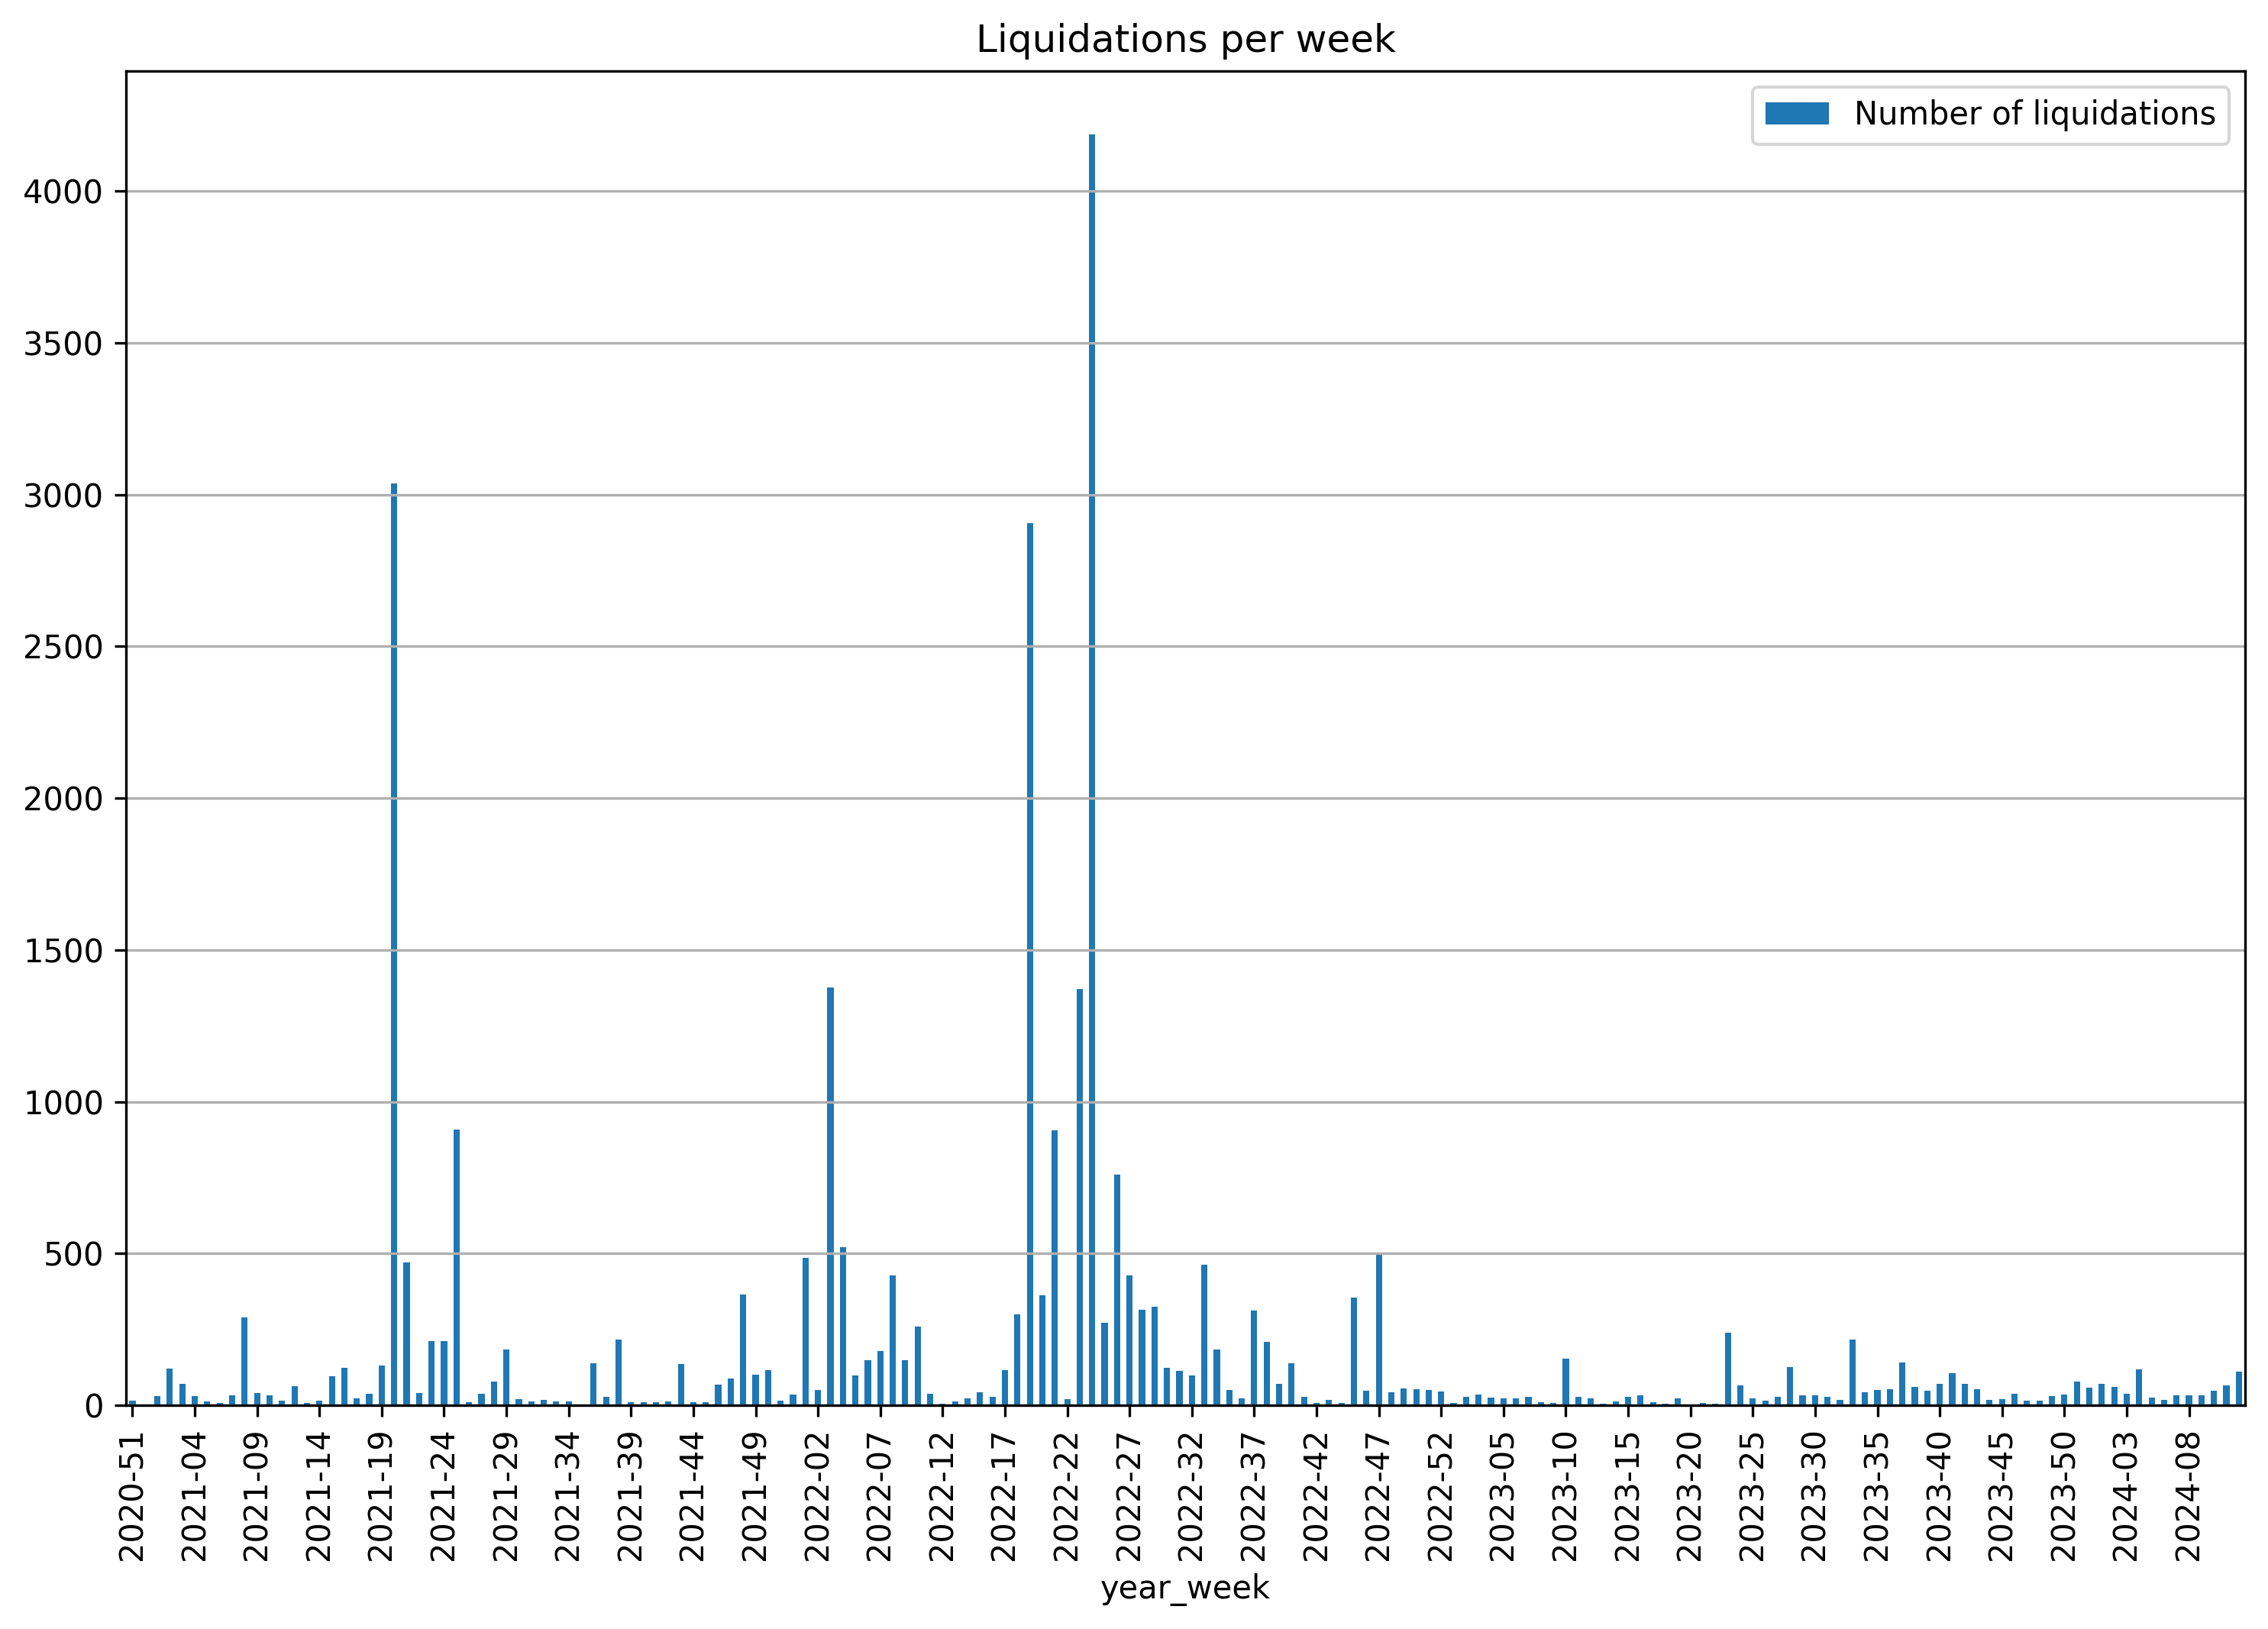

In [103]:
# Weekly liquidations

import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as ticker
import pandas as pd

style.use('default')

weekly_liquidations = liquidations.with_columns(pl.col("time").dt.strftime("%Y-%W").alias("year_week")).group_by("year_week").agg(pl.len().alias("Number of liquidations"))
weekly_liquidations = weekly_liquidations.sort("year_week")

# Plotting
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)

# Now we generate a full range of year-week values
# Assuming 'datetime' is within a reasonable date range, adjust as needed
all_weeks = pd.Series(pd.date_range(liquidations['time'].min(), liquidations['time'].max(), freq='W-MON'))
all_weeks = all_weeks.dt.strftime('%Y-%W').to_frame(name='year_week')

# Merge the full range with the actual data, filling missing weeks with 0
weekly_liquidations = pl.from_pandas(all_weeks).join(weekly_liquidations, on='year_week', how='left').fill_nan(0)
weekly_liquidations_df = weekly_liquidations.to_pandas()
weekly_liquidations_df.plot(kind='bar', x='year_week', y='Number of liquidations', ax=ax)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))

plt.tight_layout()
ax.grid(axis="y")
ax.set_title('Liquidations per week')
plt.show()


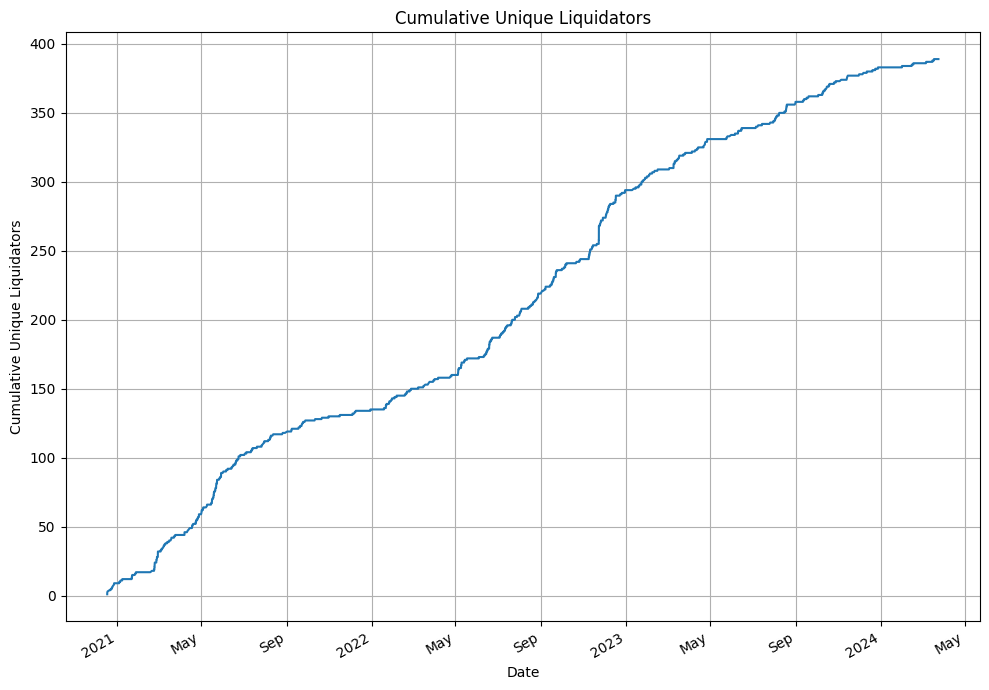

In [105]:
import matplotlib.dates as mdates

# Group by date and collect unique liquidators for each date
df_agg = liquidations.group_by("time").agg(
    pl.col("liquidator").unique().alias("unique_liquidators_per_day")
)

# Sort by date to ensure correct cumulative operation
df_agg = df_agg.sort("time")

# Get a list of dates and corresponding unique liquidators
dates = df_agg['time'].to_list()
unique_liquidators_per_day = df_agg['unique_liquidators_per_day'].to_list()

# Set to keep track of all unique liquidators seen so far
all_unique_liquidators = set()
cumulative_counts = []

# Iterate over each group's unique liquidators, updating the set and cumulative count
for liquidators in unique_liquidators_per_day:
    all_unique_liquidators.update(liquidators)
    cumulative_counts.append(len(all_unique_liquidators))

# Add the cumulative count to the DataFrame
df_agg = df_agg.with_columns(pl.Series("cumulative_unique_liquidators", cumulative_counts))

# Convert the Polars DataFrame to a Pandas DataFrame for plotting
df_agg_pd = df_agg.to_pandas()

# Plotting the cumulative number of unique liquidators over time
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the line graph
ax.plot(df_agg_pd['time'], df_agg_pd['cumulative_unique_liquidators'])

# Set the x-axis major locator to AutoDateLocator and the formatter to ConciseDateFormatter
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Add grid, labels, title, and layout adjustment
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Unique Liquidators')
ax.set_title('Cumulative Unique Liquidators')
fig.autofmt_xdate()  # Auto formats the x-axis labels to fit and avoid overlap

plt.tight_layout()
plt.show()

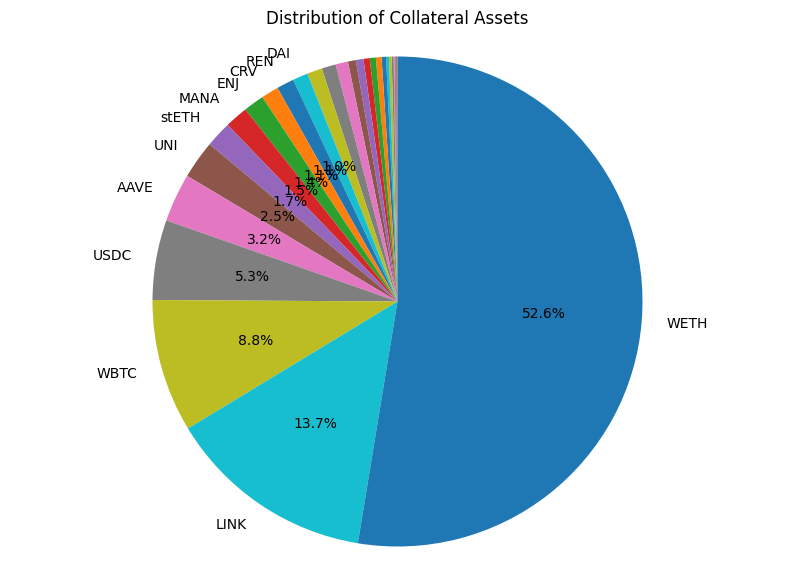

In [108]:
# Collateral Assets

collateral_distribution = liquidations.group_by("collateralAsset").agg(pl.count("collateralAsset").alias("count"))
collateral_distribution = collateral_distribution.sort("count")

labels = [get_symbol(Web3.to_checksum_address(asset)) for asset in collateral_distribution["collateralAsset"].to_list()]
sizes = collateral_distribution["count"].to_list()
total = sum(sizes)
labels = [label if (size / total) > 0.01 else '' for label, size in zip(labels, sizes)]

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%' if p > 1 else '', startangle=90)
plt.title('Distribution of Collateral Assets')
plt.axis('equal')
plt.show()

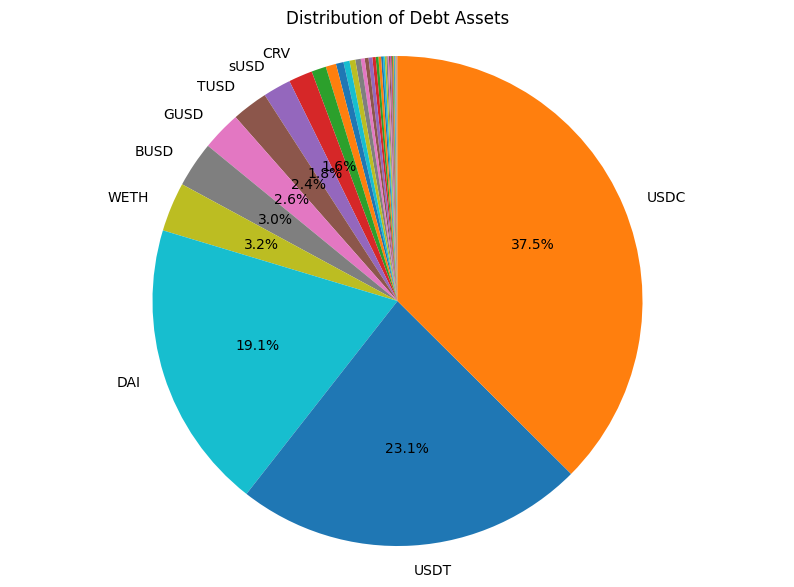

In [109]:
# Debt Assets

debt_distribution = liquidations.group_by("debtAsset").agg(pl.count("debtAsset").alias("count"))
debt_distribution = debt_distribution.sort("count")

labels = [get_symbol(Web3.to_checksum_address(asset)) for asset in debt_distribution["debtAsset"].to_list()]
sizes = debt_distribution["count"].to_list()
total = sum(sizes)
labels = [label if (size / total) > 0.01 else '' for label, size in zip(labels, sizes)]

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%' if p > 1 else '', startangle=90)
plt.title('Distribution of Debt Assets')
plt.axis('equal')
plt.show()

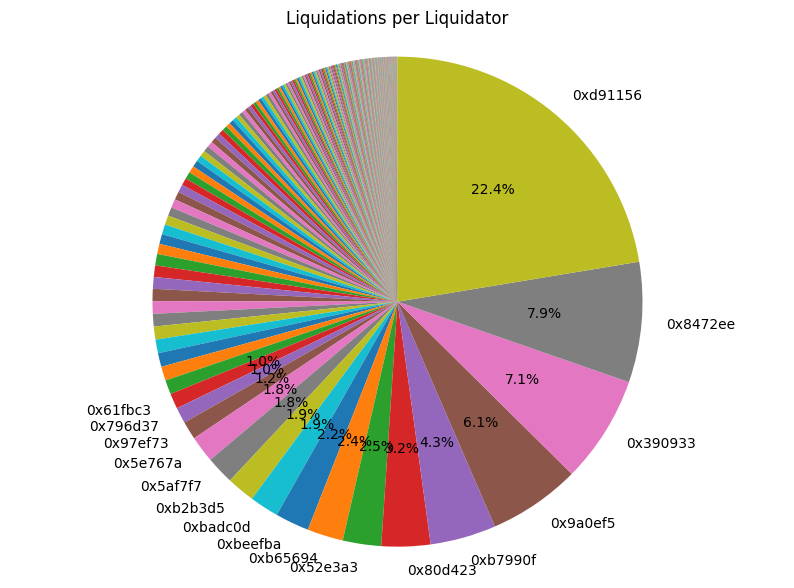

In [81]:
# Liquidations per liquidator

liquidations_per_liquidator = liquidations.group_by("liquidator").agg(pl.count("liquidator").alias("liquidation_count"))
liquidations_per_liquidator = liquidations_per_liquidator.with_columns(pl.col("liquidation_count").cast(pl.Int64))
liquidations_per_liquidator = liquidations_per_liquidator.sort("liquidation_count")

labels = liquidations_per_liquidator['liquidator'].to_list()
sizes = liquidations_per_liquidator['liquidation_count'].to_list()
total = sum(sizes)
labels = [label[:8] for label in labels]
labels = [label if (size / total) > 0.01 else '' for label, size in zip(labels, sizes)]

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%' if p > 1 else '', startangle=90)
plt.title('Liquidations per Liquidator')
plt.axis('equal')
plt.show()


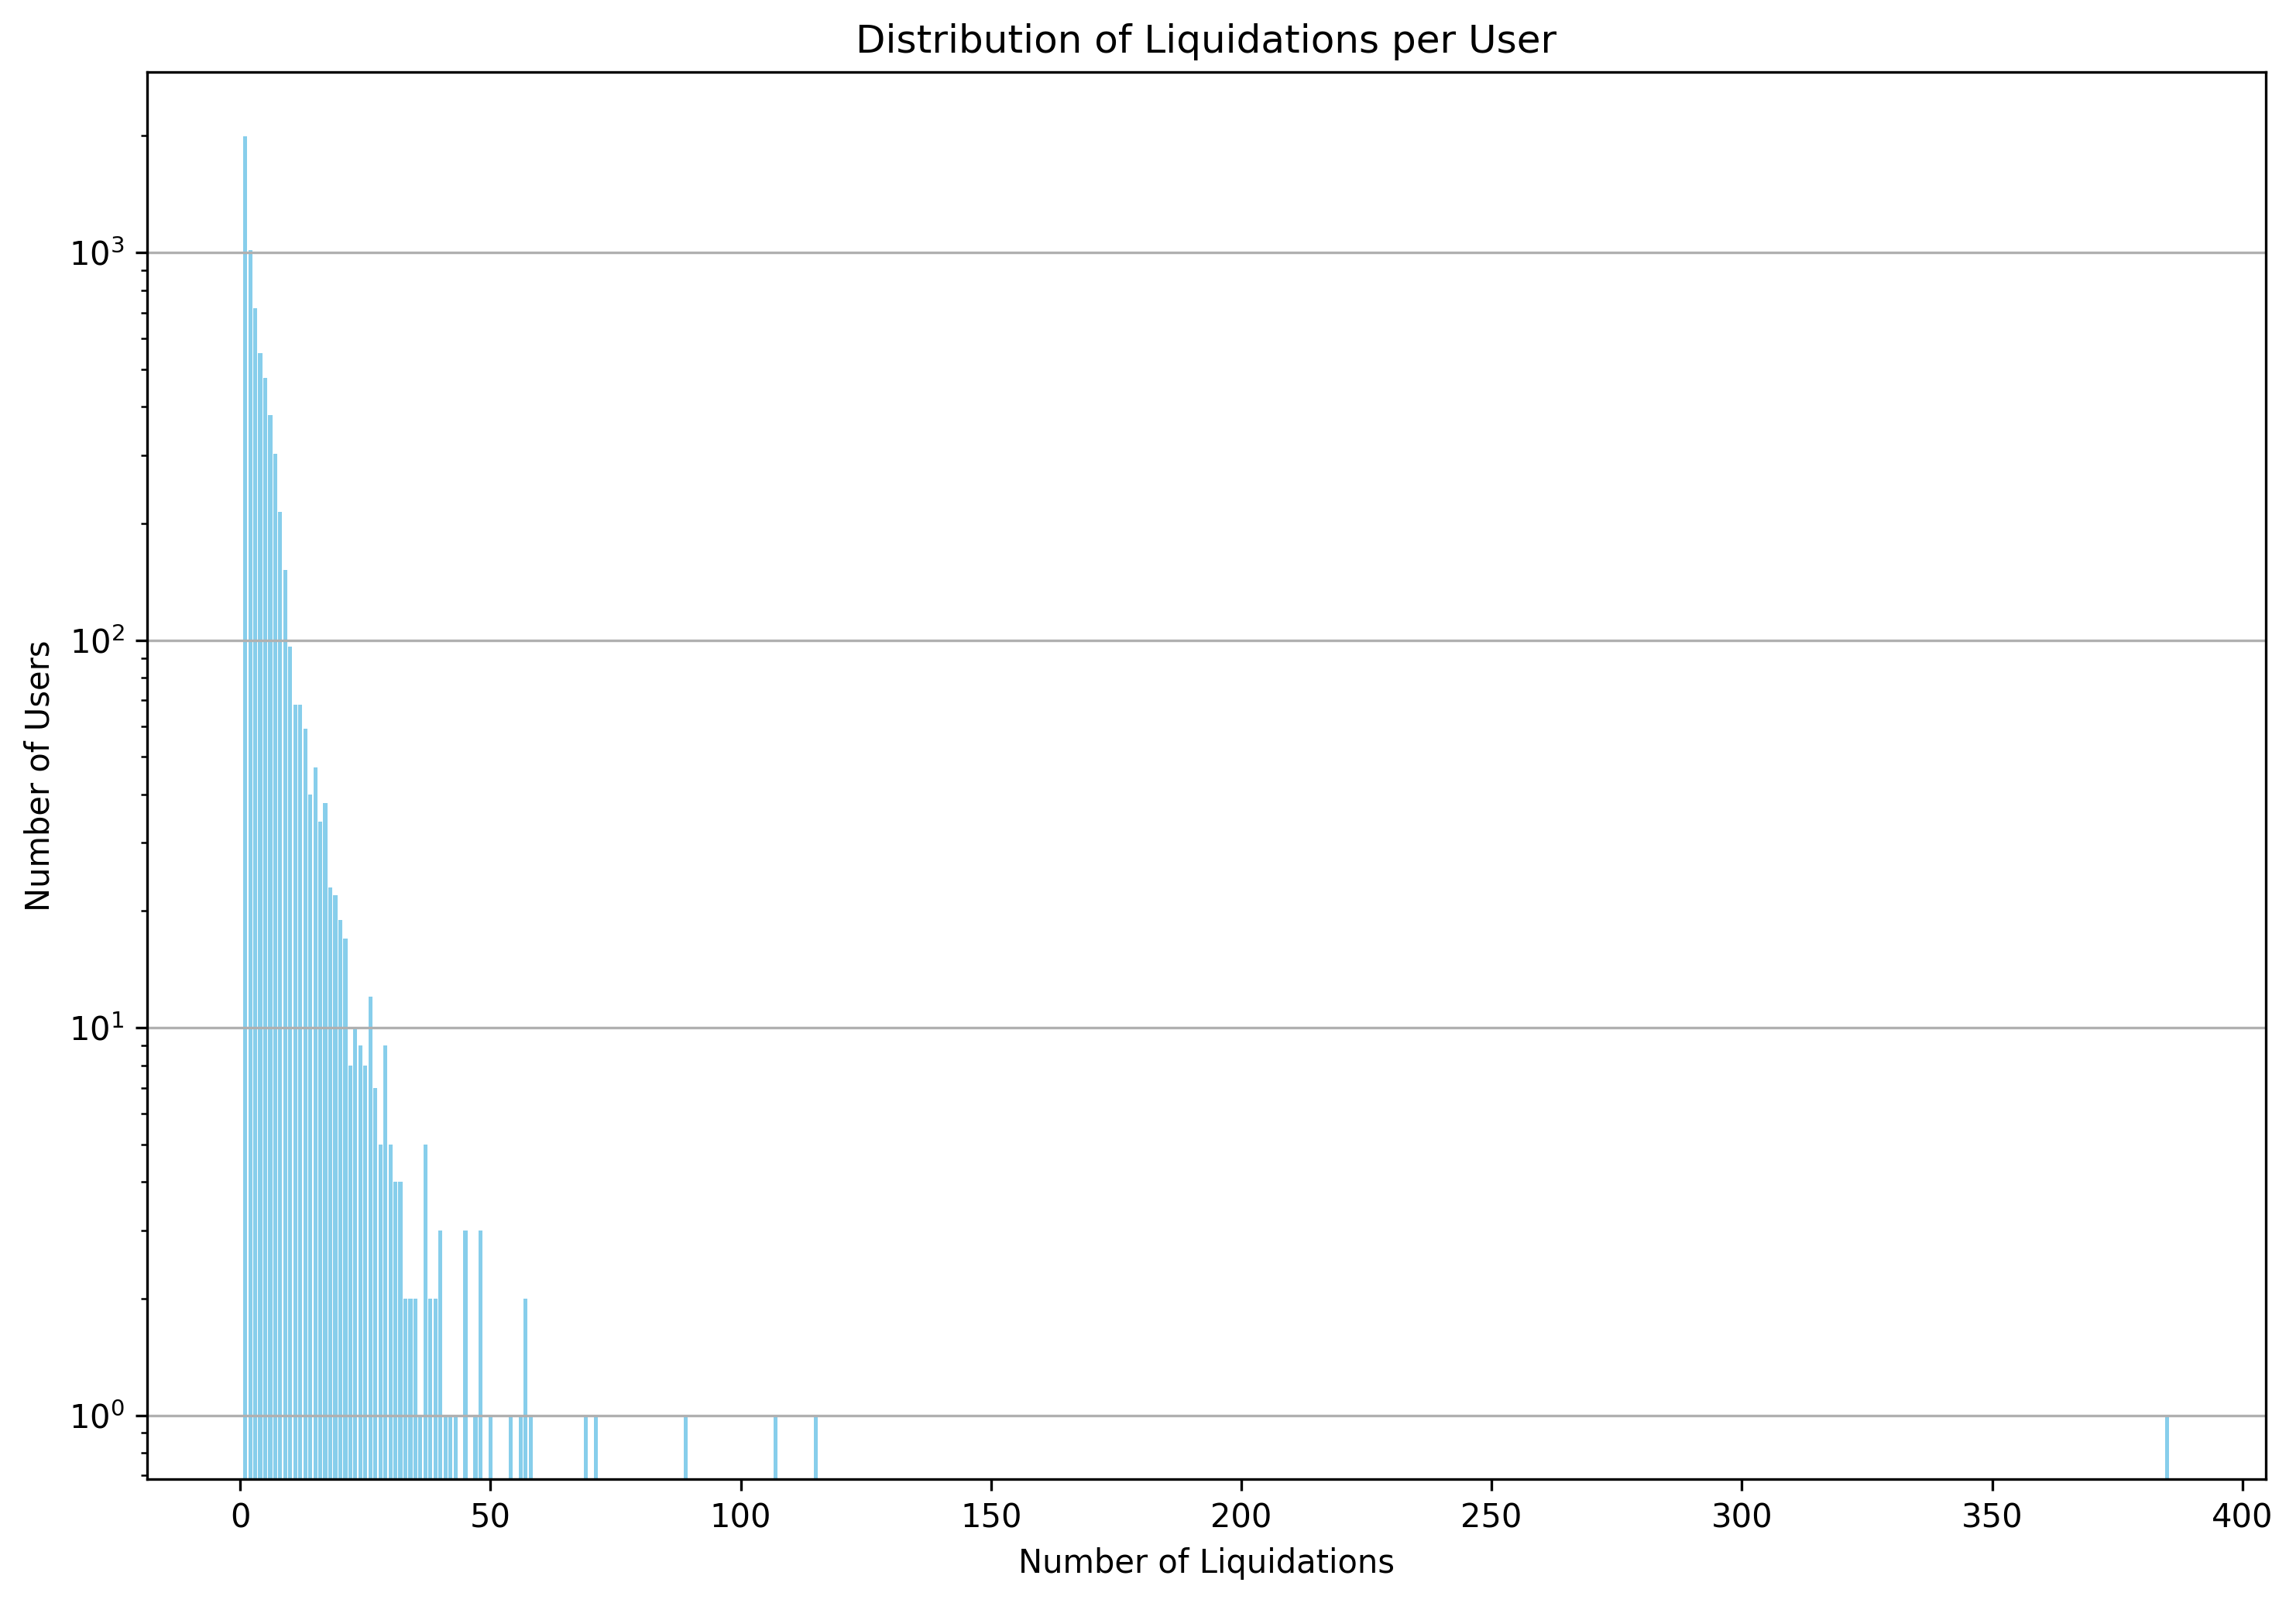

In [91]:
# Users Liquidations

user_liquidations = liquidations.group_by("user").agg(pl.count("user").alias("liquidation_count"))
liquidation_frequencies = user_liquidations.group_by("liquidation_count").agg(pl.count("user").alias("number_of_users"))
liquidation_frequencies = liquidation_frequencies.sort("liquidation_count")

plt.figure(figsize=(10, 7), dpi=300)
plt.bar(liquidation_frequencies['liquidation_count'].to_list(), liquidation_frequencies['number_of_users'].to_list(), color='skyblue')
plt.xlabel('Number of Liquidations')
plt.ylabel('Number of Users')
plt.title('Distribution of Liquidations per User')
plt.xticks(liquidation_frequencies['liquidation_count'].to_list())
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.gca().set_yscale('log')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [116]:
user_liquidations.sort("liquidation_count").tail(1)["user"].to_list()[0]

'shape: (1,)\nSeries: \'user\' [str]\n[\n\t"0x57e04786e231…\n]'